In [1]:
import rtde_control
import rtde_receive
import numpy as np
import sys
import yaml
from matplotlib import pyplot as plt
# import SimpleITK as sitk
import pickle as pkl
import pyrealsense2 as rs
import cv2
import scipy
plt.rcParams['figure.figsize'] = [10, 10]

In [37]:
def get_frame(pipeline, gray=False):
    frames = pipeline.wait_for_frames()
    rgb = frames.get_color_frame()
    depth = frames.get_depth_frame()
    pc = rs.pointcloud()
    # points = pc.calculate(depth).get_vertices()  
    rgb_img = np.asanyarray(rgb.get_data())
    return rgb_img[:, :, 0] if gray else rgb_img

def show_frame(img, gray=False, save=False, save_name='img.png'):
    fig, ax = plt.subplots()
    if not gray:
        ax.imshow(img)
    else:
        if len(img.shape) == 3:
            img = img[:, :, 0]
        ax.imshow(img, cmap='gray')
    if save:
        if save_name is not None:
            cv2.imwrite(save_name, img)
        else:
            cv2.imwrite('img_temp.png', img)

def rotate_robot(rtde_c, rtde_r, angles, speed=0.005):
    """rotate TCP by angle on x axis.

    Args:
        rtde_c 
        rtde_r 
        angle (float): degree of rotation of x axis.
    """
    tcp_pose = rtde_r.getActualTCPPose()
    rads = [angle / 180 * np.pi for angle in angles]
    target_pose = rtde_c.poseTrans(tcp_pose, [0, 0, 0] + rads)
    return rtde_c.moveL(target_pose,speed=speed,acceleration=0.1)

### Connect to robots

In [97]:
rtde_c = rtde_control.RTDEControlInterface("192.168.1.2")
rtde_r = rtde_receive.RTDEReceiveInterface("192.168.1.2")


### Connect to cameras

In [4]:
pipeline = rs.pipeline()
pipeline.start()

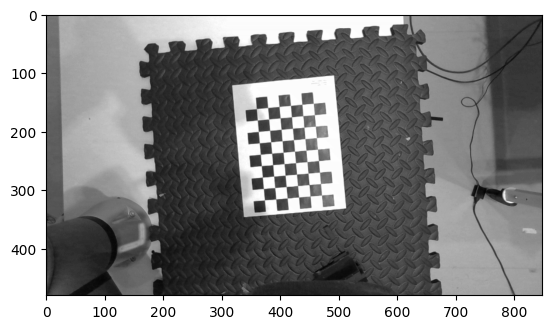

In [11]:
frame = get_frame(pipeline, gray=True)
show_frame(frame,gray=True, save=True)

### Let the robot rotate the camera

In [89]:
with open('pose_in_TCP_frame.yaml','r') as f:
    poses = yaml.safe_load(f)

    camera_2_tcp = poses['camera']
    probe_2_tcp = poses['probe']
rtde_c.setTcp(probe_2_tcp)

True

In [98]:
rtde_c.setTcp([0,0,0,0,0,0])

True

Reconnecting...


RTDEControlInterface: Could not receive data from robot...
RTDEControlInterface Exception: Operation canceled
RTDEControlInterface: Robot is disconnected, reconnecting...
RTDEReceiveInterface Exception: Operation canceled


Dashboard client deadline expired


RTDEControlInterface Exception: Timeout connecting to UR dashboard server.


In [91]:
rotate_robot(rtde_c, rtde_r, [-20, 20, 0], speed=0.02)

True

get another frame and save

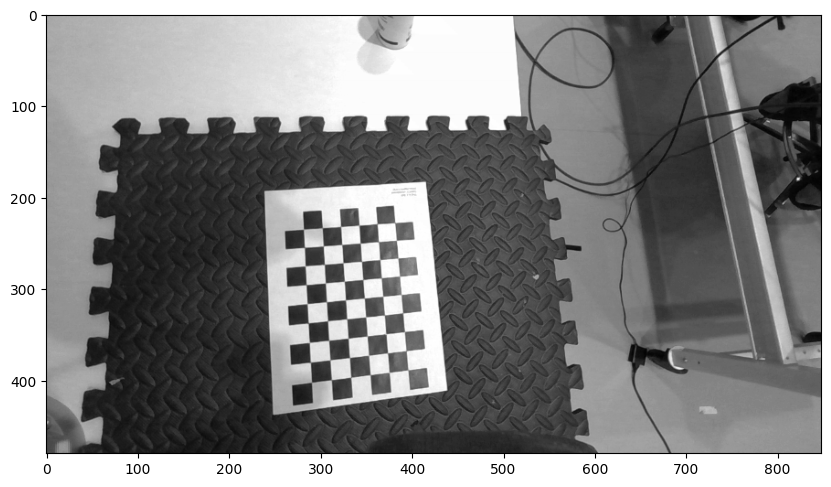

In [45]:
img2 = get_frame(pipeline, gray=True)
show_frame(img2, gray=True, save=True, save_name='img5.png')

### Read saved img and start to do calibration

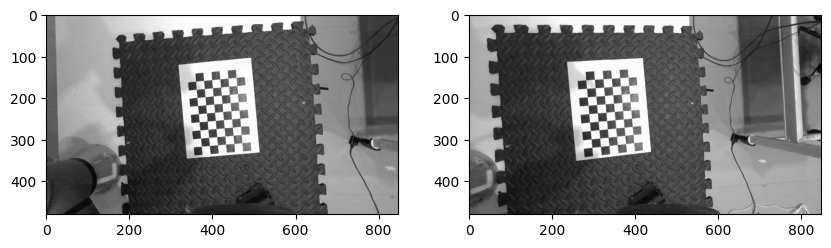

In [33]:
def get_A(fname):
    img1 = cv2.imread('img1.png')
    img2 = cv2.imread(fname)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img1, cmap='gray')
    ax2.imshow(img2, cmap='gray')

    # Create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # Get SIFT keypoints and descriptors for each image
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Create a BF matcher object using the L2 norm
    bf = cv2.BFMatcher(cv2.NORM_L2)

    # Match descriptors (in both directions) between each pair of adjacent images
    matches12 = bf.match(des1, des2)
    matches21 = bf.match(des2, des1)

    matches12_sym = []
    for i in range(len(matches12)):
        j = matches12[i].trainIdx
        # Only include j if it maps back to i
        if matches21[j].trainIdx == i:
            matches12_sym.append((i, j))

    N = 400  # Number of matches to use in each image pair
    # Find the N pairs with the lowest symmetric distance in each image pair
    matches12_sym = sorted(matches12_sym, key=lambda x: matches12[x[0]].distance + matches21[x[1]].distance)[:N]

    # Get coordinates
    X12 = np.array([kp1[i].pt for i, _ in matches12_sym])
    X21 = np.array([kp2[j].pt for _, j in matches12_sym])

    # Plot points

    # ax2.imshow(img2, cmap='gray')
    # ax1.scatter(X12[:, 0], X12[:, 1], s=5)
    # ax2.plot(X21[:, 0], X21[:, 1], 'or')

    # cv2.getPerspectiveTransform(X12, X21)
    M, mask = cv2.findHomography(X12, X21, cv2.RANSAC, 1.0)

    # Apply the perspective transformation to image1 to warp it to the perspective of image2
    warped_image = cv2.warpPerspective(img1, M, (img2.shape[1], img2.shape[0]))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(warped_image, cmap='gray')
    ax2.imshow(img2, cmap='gray')

    print('homography', M)

    M_inv_t = np.linalg.inv(M).T
    A = np.array([
        [M_inv_t[0, 0] - M[0, 0], M_inv_t[1, 0] - M[0, 1], M_inv_t[2, 0] - M[0, 2], 0,             0,             0],
        [M_inv_t[0, 1],           M_inv_t[1, 1] - M[0, 0], M_inv_t[2, 1],           -M[0, 1],      -M[0, 2],      0],
        [M_inv_t[0, 2],           M_inv_t[1, 2],           M_inv_t[2, 2] - M[0, 0], 0,             -M[0, 1],      -M[0, 2]],
        [-M[1, 0],                M_inv_t[0, 0] - M[1, 1], -M[1, 2],                M_inv_t[1, 0], M_inv_t[2, 0], 0],
        [0,                       M_inv_t[0, 1] - M[1, 0], 0,                       M_inv_t[1, 1] - M[1, 1], M_inv_t[2, 1] - M[1, 2], 0],
        [0,                       M_inv_t[0, 2],           -M[1, 0], M_inv_t[1, 2], M_inv_t[2, 2] - M[1, 1], -M[1, 2]],
        # [-M[2, 0], -M[2, 1], M_inv_t[0, 0] - M[2, 2], 0, M_inv_t[1, 0], M_inv_t[2, 0]],
        # [0, -M[2, 0], M_inv_t[0, 1], -M[2, 1], M_inv_t[1, 1] - M[2, 2], M_inv_t[2, 1]],
        # [0, 0, M_inv_t[0, 2] - M[2, 0], 0, M_inv_t[1, 2] - M[2, 1], M_inv_t[2, 2] - M[2, 2]]
    ])

    return A

In [24]:
np.linalg.inv(M).T

array([[ 6.80995717e-01, -7.45253546e-02, -3.10296988e-04],
       [-1.63875080e-03,  8.20586895e-01, -8.99639740e-06],
       [ 1.17367199e+02,  2.96266624e+01,  9.46017033e-01]])

homography [[ 1.00000000e+00  5.28930038e-17 -3.39524213e-13]
 [ 1.50591764e-15  1.00000000e+00 -3.92524398e-13]
 [ 6.28252631e-18  1.76504922e-20  1.00000000e+00]]
homography [[ 1.38994811e+00  8.84928382e-04 -1.72471032e+02]
 [ 1.09736613e-01  1.21829158e+00 -5.17679815e+01]
 [ 4.56951546e-04  1.18759234e-05  1.00000000e+00]]
homography [[ 7.92755712e-01  1.58755738e-01  9.16206822e+01]
 [-7.33656085e-02  1.02271113e+00 -6.07803824e+01]
 [-3.53574186e-04  3.41340831e-04  1.00000000e+00]]
homography [[ 1.12046210e+00  1.82543482e-01 -5.07472392e+01]
 [-3.20432884e-04  1.20481307e+00 -1.06397709e+02]
 [ 3.01765943e-06  4.28193642e-04  1.00000000e+00]]
homography [[ 1.28638459e+00 -1.56539482e-01 -1.31128297e+02]
 [ 1.17979084e-01  1.01294110e+00  5.01768994e+01]
 [ 4.26855870e-04 -3.98382306e-04  1.00000000e+00]]


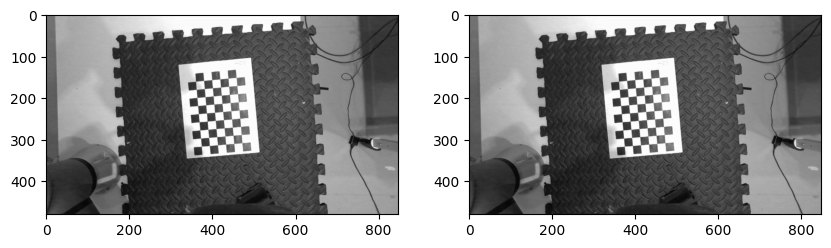

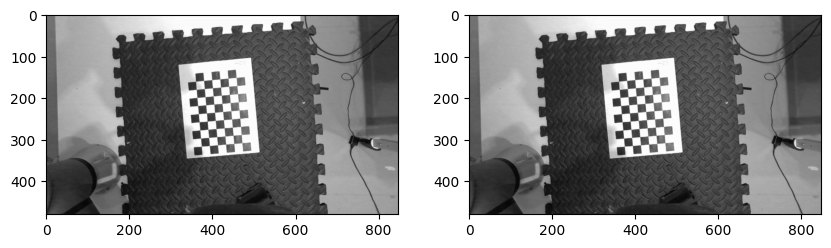

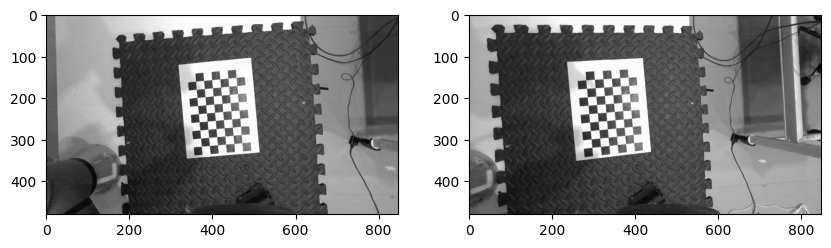

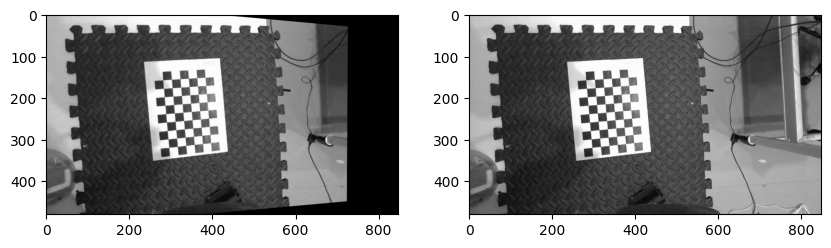

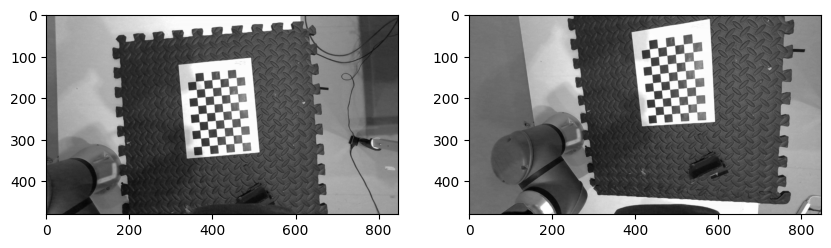

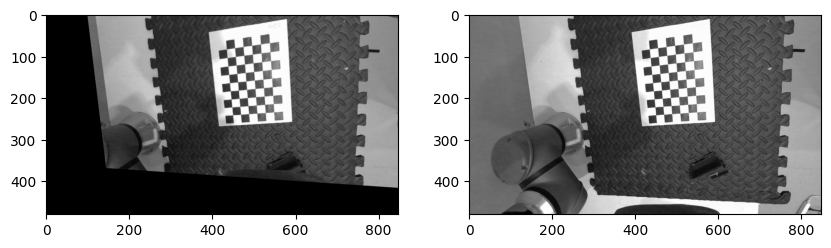

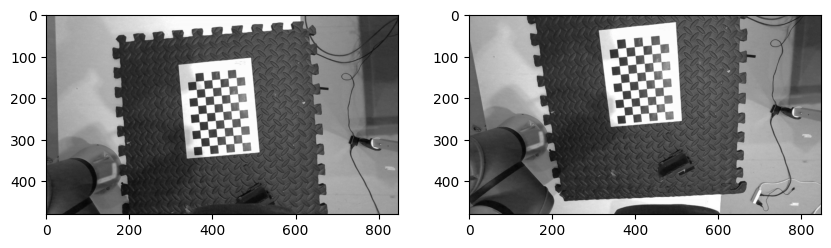

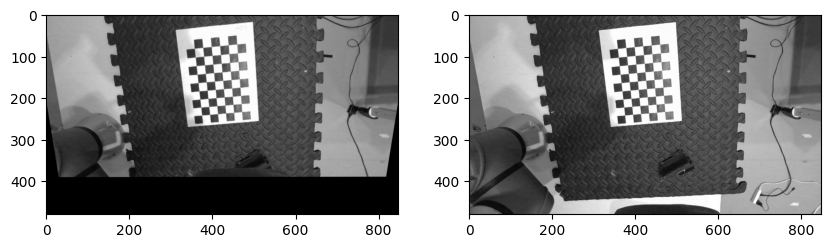

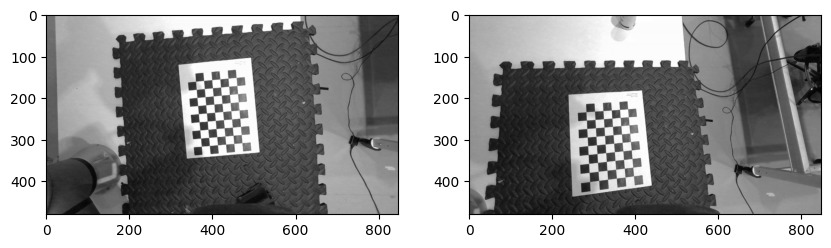

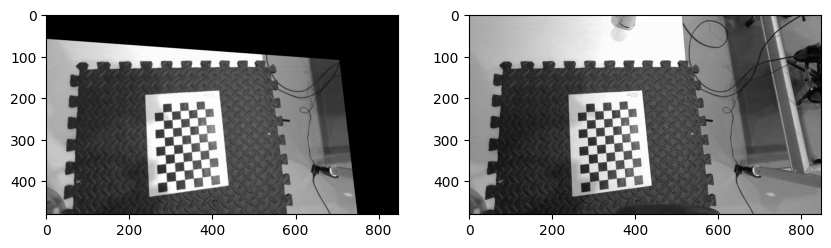

In [34]:
As = []
for i in range(1, 6):
    As.append(get_A('img{}.png'.format(str(i))))

In [35]:
A = np.vstack(As)
_, Sig, V = np.linalg.svd(A)
a, b, c, d, e, f = V[-1] #/ V[-1][-1]
print('smallest singular value', Sig[-1])

smallest singular value 0.31483810196839196


In [37]:
C = np.array([
    [a, b, c],
    [b, d, e],
    [c, e, f]
])
C

K = scipy.linalg.cholesky(C)
K / K [-1, -1]
# K @ K.T - C
# K / K[-1, -1]

array([[9.99560740e+02, 9.58487110e+01, 2.11086648e+00],
       [0.00000000e+00, 7.87489262e+02, 8.26418487e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [67]:
np.load('cameraMatrix.npy')

array([[390.32024429,   0.        , 321.19607036],
       [  0.        , 390.72719073, 243.69618418],
       [  0.        ,   0.        ,   1.        ]])